In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile 
from pathlib import Path
import os
from tqdm import tqdm
import sys
import aligner as alg
sys.path.append('..')
from Onlypores import onlypores

# AUX

In [11]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

# Load

In [12]:
filename = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\10\volume_eq')

data = read_sequence(filename)

# data = np.pad(data, ((10,10),(10,10),(10,10)), 'constant', constant_values=(38,38))

mask = onlypores.material_mask(data)

Progress: 100%|██████████| 3226/3226 [00:39<00:00, 81.25it/s]


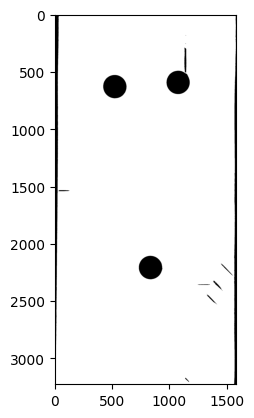

In [13]:
plt.imshow(mask[:,:,100], cmap='gray')

# CODE

In [14]:
# /e:/VisionPy/VisionPy2/align_sample.py

import numpy as np
from scipy.ndimage import affine_transform
from scipy.spatial.transform import Rotation as R

def align_sample(volume, mask):
    """
    Aligns the CFRP sample with the coordinate axes.

    Parameters:
    volume (np.ndarray): 3D NumPy array of the grayscale volume.
    mask (np.ndarray): 3D NumPy array of the binary mask.

    Returns:
    aligned_volume (np.ndarray): Aligned grayscale volume.
    aligned_mask (np.ndarray): Aligned binary mask.
    """
    # Estimate the orientation of the sample using the binary mask
    coords = np.column_stack(np.where(mask))
    cov_matrix = np.cov(coords, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Ensure the eigenvectors are sorted by eigenvalues in descending order
    sorted_indices = np.argsort(-eigvals)
    eigvecs = eigvecs[:, sorted_indices]

    # Compute the best transformation (rotation) to align the sample with the axes
    rotation_matrix = eigvecs
    rotation = R.from_matrix(rotation_matrix)
    rotation_matrix = rotation.as_matrix()

    # Center of the volume
    center = np.array(volume.shape) / 2

    # Apply the transformation to both the volume and the mask
    aligned_volume = affine_transform(volume, rotation_matrix, offset=center - rotation_matrix @ center, order=1)
    aligned_mask = affine_transform(mask, rotation_matrix, offset=center - rotation_matrix @ center, order=0)

    return aligned_volume, aligned_mask

In [15]:
aligned_volume, aligned_mask = align_sample(data, mask)

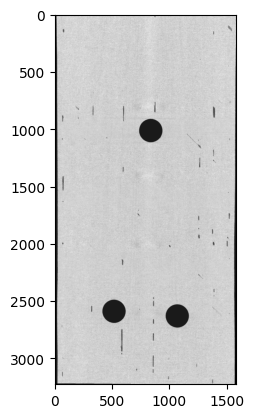

In [16]:
plt.imshow(aligned_volume[:,:,100], cmap='gray')

In [17]:
aligned_volume, aligned_mask = align_sample(aligned_volume, aligned_mask)

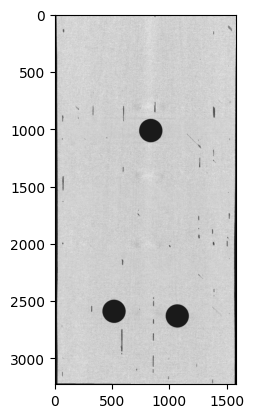

In [18]:
plt.imshow(aligned_volume[:,:,100], cmap='gray')